Proyecto realizado para el curso fundamentos de Spark para Big Data basado en los contenidos del curso Spark de Udacity:

https://www.udacity.com/course/learn-spark-at-udacity--ud2002


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [44]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import desc
from pyspark.sql.functions import sum as Fsum
import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
spark=SparkSession.builder.appName("Proyecto").getOrCreate()

In [7]:
path = "drive/MyDrive/sparkify_log_small.json" #Ruta de archivo de donde se cargara datos
user_log = spark.read.json(path) #cargar los datos (JSON)

In [8]:
user_log.printSchema() #Visualizar esquema de datos

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
user_log.show(n=1) #mostrar una fila de la tabla

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------

In [10]:
user_log.count() #Contar las filas

10000

Seleccionemos los distinos registros de la columna page

In [ ]:
#selecciona una columna con select, con dropDuplicates quita los duplicados con sort los organiza alfabeticamente
#y con show los muestra
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



Veamos los registros en las columnas userId, firstname, page y song para el usuario con userId 1046

In [11]:
#Filtra para el usuario 1046 el registro con esas 4 columnas
user_log.select(["userId", "firstname","page", "song"]).where(user_log.userId == "1046").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

Analicemos el numero de canciones que se escuchan por hora

In [14]:
#Funcion para obtener la hora de una columna
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

#Devuelve un nuevo DataFrame añadiendo una columna o sustituyendo la columna existente que tiene el mismo nombre
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [16]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='22')

In [17]:
#Filtra filas con la condición page == "NextSong", agrupa por hora, cuenta filas en cada grupo y ordena por hora
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [18]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  456|
|   1|  454|
|   2|  382|
|   3|  302|
|   4|  352|
|   5|  276|
|   6|  348|
|   7|  358|
|   8|  375|
|   9|  249|
|  10|  216|
|  11|  228|
|  12|  251|
|  13|  339|
|  14|  462|
|  15|  479|
|  16|  484|
|  17|  430|
|  18|  362|
|  19|  295|
+----+-----+
only showing top 20 rows



In [19]:
songs_in_hour_pd = songs_in_hour.toPandas() #convertir a dataframe de Pandas
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour) #convierte elementos de tipo horaria en tipo números (una buena práctica a aplicar siempre)

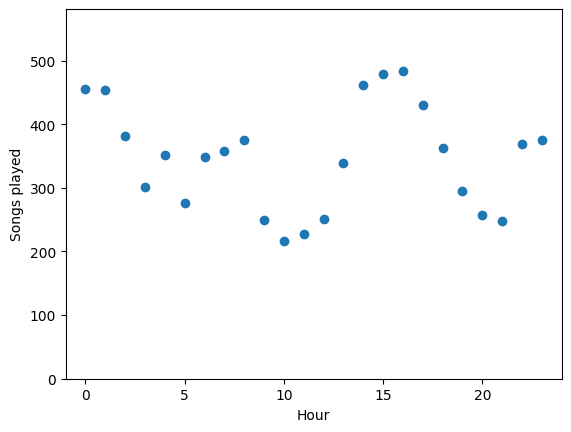

In [20]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

Limpiemos registros de usuarios no registrados (No tiene registro en UserId o sessionId)

In [21]:
#eliminar valores con NaN UserId o sessionId
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [22]:
user_log_valid.count()

10000

In [23]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [25]:
#generar dataframe conservando sólo los userId con números válidos (eliminando los userId con espacio vacío)
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [26]:
user_log_valid.count()

9664

Ánalisis de personas que hacen downgrade a su suscripción

In [27]:
#Returnar la primera persona en hacer downgrade de la suscripción
user_log_valid.filter("page = 'Submit Downgrade'").show()


+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  11|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [28]:
#Muestra las columnas señaladas para el userId en específico
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "1138").collect()


[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [29]:
#funcion lambda para marcar evento de downgrade. Devuelve 1 si en la columna page el aparece Submit Downgrade sino 0
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType()) #El IntegerType lo pasa a entero

In [30]:
#agrega columna a user_log_valid de nombre downgraded y con valor dado por la función anterior
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='22', downgraded=0)

In [41]:
#crea una ventana donde particiona los datos por UserId, los ordena temporalmente de mayor a menor en el rango todos
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [33]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [34]:
#Lo que muestra está ordenado del evento más viejo al más reciente (pero el Fsum lo hace en el sentido contrario)
#lo anterior para que los eventos después de downgrade sumen 0 la fase y los otros 1
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

Con lo anterior podemos observar en que instante el usuario hace un downgrade pues la fase cambia de 1 a 0

Veamos que páginas los usuarios con userId " " no visita

In [ ]:
user_log.select(["page"]).where(user_log.userId == "").dropDuplicates().sort("page").show()

+-----+
| page|
+-----+
|About|
| Help|
| Home|
|Login|
+-----+



In [ ]:
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



Si comparamos las dos tabla vemos que estos usuarios son los que no se registarn en la plataforma y por tanto no escuchan música en ella

Veamos el número de usuarias mujeres

In [37]:
#Listamos los géneros
user_log.select(["gender"]).dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+



In [38]:
#Contamos los usuarios femeninos (gender = F)
user_log.select(["userId","gender"]).where(user_log.gender == "F").dropDuplicates(["userId"]).count()

462

Veamos cuál es el artista más escuchado

In [ ]:

user_log.select(["artist"]).groupby(user_log.artist).count().orderBy(desc("count")).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null| 1653|
|            Coldplay|   83|
|       Kings Of Leon|   69|
|Florence + The Ma...|   52|
|            BjÃÂ¶rk|   46|
|       Dwight Yoakam|   45|
|       Justin Bieber|   43|
|      The Black Keys|   40|
|         OneRepublic|   37|
|        Jack Johnson|   36|
|                Muse|   36|
|           Radiohead|   31|
|        Taylor Swift|   29|
|               Train|   28|
|Barry Tuckwell/Ac...|   28|
|          Lily Allen|   28|
|           Metallica|   27|
|          Nickelback|   27|
|           Daft Punk|   27|
|          Kanye West|   26|
+--------------------+-----+
only showing top 20 rows



Es Coldplay

Analicemos cuántas canciones escuchan de media los usuarios entre visita y visita a página de inicio

In [45]:
ishome = udf(lambda page: int(page == 'Home'), IntegerType()) #Marca con 1 cuando aparece home

In [46]:
# Define window function donde particiona por UserId y ordena temporalmente de más reciente a menos
user_window = Window \
    .partitionBy('userId') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

In [ ]:
# Step 1: Flagea página como homevisit; Step 2: Acumula homevisit como period
# En period al sumar cumulativamente hasta que no aparezca un 1 de page = Home, los numeros permanecen igual y así se pueden agrupar después
# Con el operador lógico (|) se se serciora solo de coger los eventos de interes pues lo que pasa en los otros eventos no es importante (no dan play canciones)

cusum = user_log.where((user_log.page == 'NextSong') | (user_log.page == 'Home')) \
            .select(['userId', 'page', 'ts']) \
            .withColumn('homevisit', ishome('page')) \
            .withColumn('period', Fsum('homevisit').over(user_window))

In [ ]:
# Step 3: Cuenta period donde page = 'NextSong'. Filtra,os page != 'Home' porque es el límite de cada Home y NextSong
# Step 4: Calcula cuántas canciones escuchan de media los usuarios entre que visitan nuestra página de inicio.
cusum.where(cusum.page == 'NextSong') \
    .select('*') \
    .groupBy('userId', 'period') \
    .agg({'period': 'count'}) \
    .agg({'count(period)': 'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 6.898347107438017|
+------------------+



En media los usuarios escuchan 7 canciones antes de visitar la página de inicio